In [18]:
import sys
sys.path.append('../src')

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from data import DataGeneratingProcess, SyntheticDataset
from models import MLP
from utils import set_seed, Trainer

In [19]:
period = 20
seq_len = 10000
𝜆 = 1
p = 0.5

dp = DataGeneratingProcess(period=period, seq_len=seq_len, num_seeds=3, 𝜆=𝜆, p=p)
dp.generate_data()

t_list = np.arange(20, 500, 1)

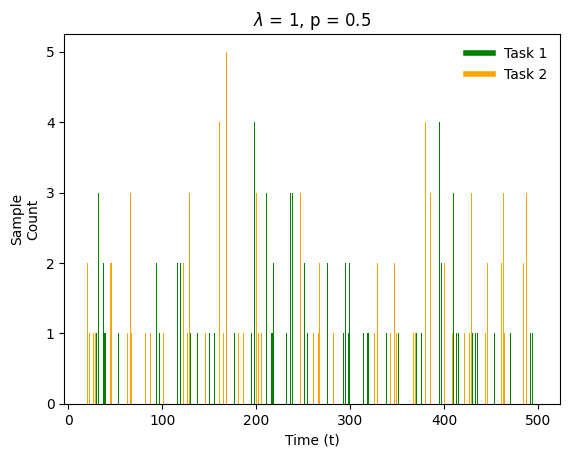

In [20]:
times = dp.data['t'][0]
tasks = np.array(dp.data['task'][0])[t_list]
sample_count_per_time = np.array([sum(times == i) for i in t_list])
colors = ['green' if tsk == 0 else 'orange' for tsk in tasks]
plt.bar(t_list, sample_count_per_time, color=colors, linewidth=0.01)
plt.ylabel("Sample\nCount")
plt.xlabel("Time (t)")
plt.title(rf"$\lambda$ = {𝜆}, p = {p}")
legend_elements = [
    Line2D([0], [0], color='green', lw=4, label='Task 1'),
    Line2D([0], [0], color='orange', lw=4, label='Task 2')
]
plt.legend(handles=legend_elements, frameon=False)
plt.show()

In [21]:
def get_dataloaders(dp, t, seed):
    """obtain the dataloaders"""
    train_dataset = SyntheticDataset(dp.data, t, seed, test=False)
    test_dataset = SyntheticDataset(dp.data, t, seed, test=True)
    ttest_dataset = TensorDataset(*dp.generate_at_time(t, 500))

    if len(train_dataset) > 32:
        bs = 32
    else:
        bs = 2
            
    trainloader = DataLoader(
        train_dataset,
        batch_size=bs,
        shuffle=True,
        drop_last=True
    )
    testloader = DataLoader(
        test_dataset, 
        batch_size=100,
        shuffle=False
    )
    ttestloader = DataLoader(
        ttest_dataset, 
        batch_size=100,
        shuffle=False
    )
    return trainloader, testloader, ttestloader

### Experiment run

In [ ]:
# configure and obtain the data generating process
period = 20
seq_len = 10000
𝜆 = 0
p = 0.0
num_seeds = 3
criterion = torch.nn.CrossEntropyLoss()

dp = DataGeneratingProcess(period=period, seq_len=seq_len, num_seeds=num_seeds, 𝜆=𝜆, p=p)
dp.generate_data()

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# learners being considered
methods = ["FTL", "Prospective"]

t_list = np.arange(20, 500, 1) # list of time steps 

instant_risk = {} # store instant risk for each algorithm
prospective_risk = {} # store prospective risk for each algorithm

for method in methods:
    instant_losses = []
    prospective_losses = []
    for seed in range(num_seeds):
        print(f"seed = {seed}")
        acorn = seed * 1000 + 1996
        set_seed(acorn)

        iloss_list = []
        ploss_list = []
        
        for t in t_list:
            print(f"time t = {t}")

            trainloader, testloader, ttestloader = get_dataloaders(dp, t, seed)
            prospective = True if "Prospective" in method else False
            model = MLP(prospective=prospective)
            model.to(device)
            optimizer = torch.optim.SGD(
                model.parameters(), 
                lr=0.1,
                momentum=0.9, 
                nesterov=True,
                weight_decay=0.00001
            )

            trainer = Trainer(model, trainloader, testloader, ttestloader, criterion, optimizer, device)
            if t > 2:
                trainer.train(num_epochs=100)
                
            iloss, ploss, _ = trainer.evaluate()
            iloss_list.append(iloss)
            ploss_list.append(ploss)

        instant_losses.append(iloss_list)
        prospective_losses.append(ploss_list)

    instant_risk[method] = np.stack(instant_losses).mean(axis=0)
    prospective_risk[method] = np.stack(prospective_losses).mean(axis=0)

### Save results

In [14]:
# save the results
import pickle
results = {
    "prisk": prospective_risk, 
    "irisk": instant_risk
}
with open(f'results_lambda_{𝜆}_p_{p}.pkl', 'wb') as file:
    pickle.dump(results, file)

### Figures

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8-whitegrid")
plt.style.use("default")
sns.set(context='poster',
            style='ticks',
            font_scale=0.9,
            rc={'axes.grid':True,
                'grid.color':'.9',
                'grid.linewidth':0.75})
plt.rcParams.update({'font.size': 16})
from matplotlib.lines import Line2D

import numpy as np
import pickle

In [2]:
def load_results(file):
    with open(file, 'rb') as file:
        results = pickle.load(file)
    return results

In [3]:
period = 20
t_list = np.arange(20, 500, 1) # list of time steps 

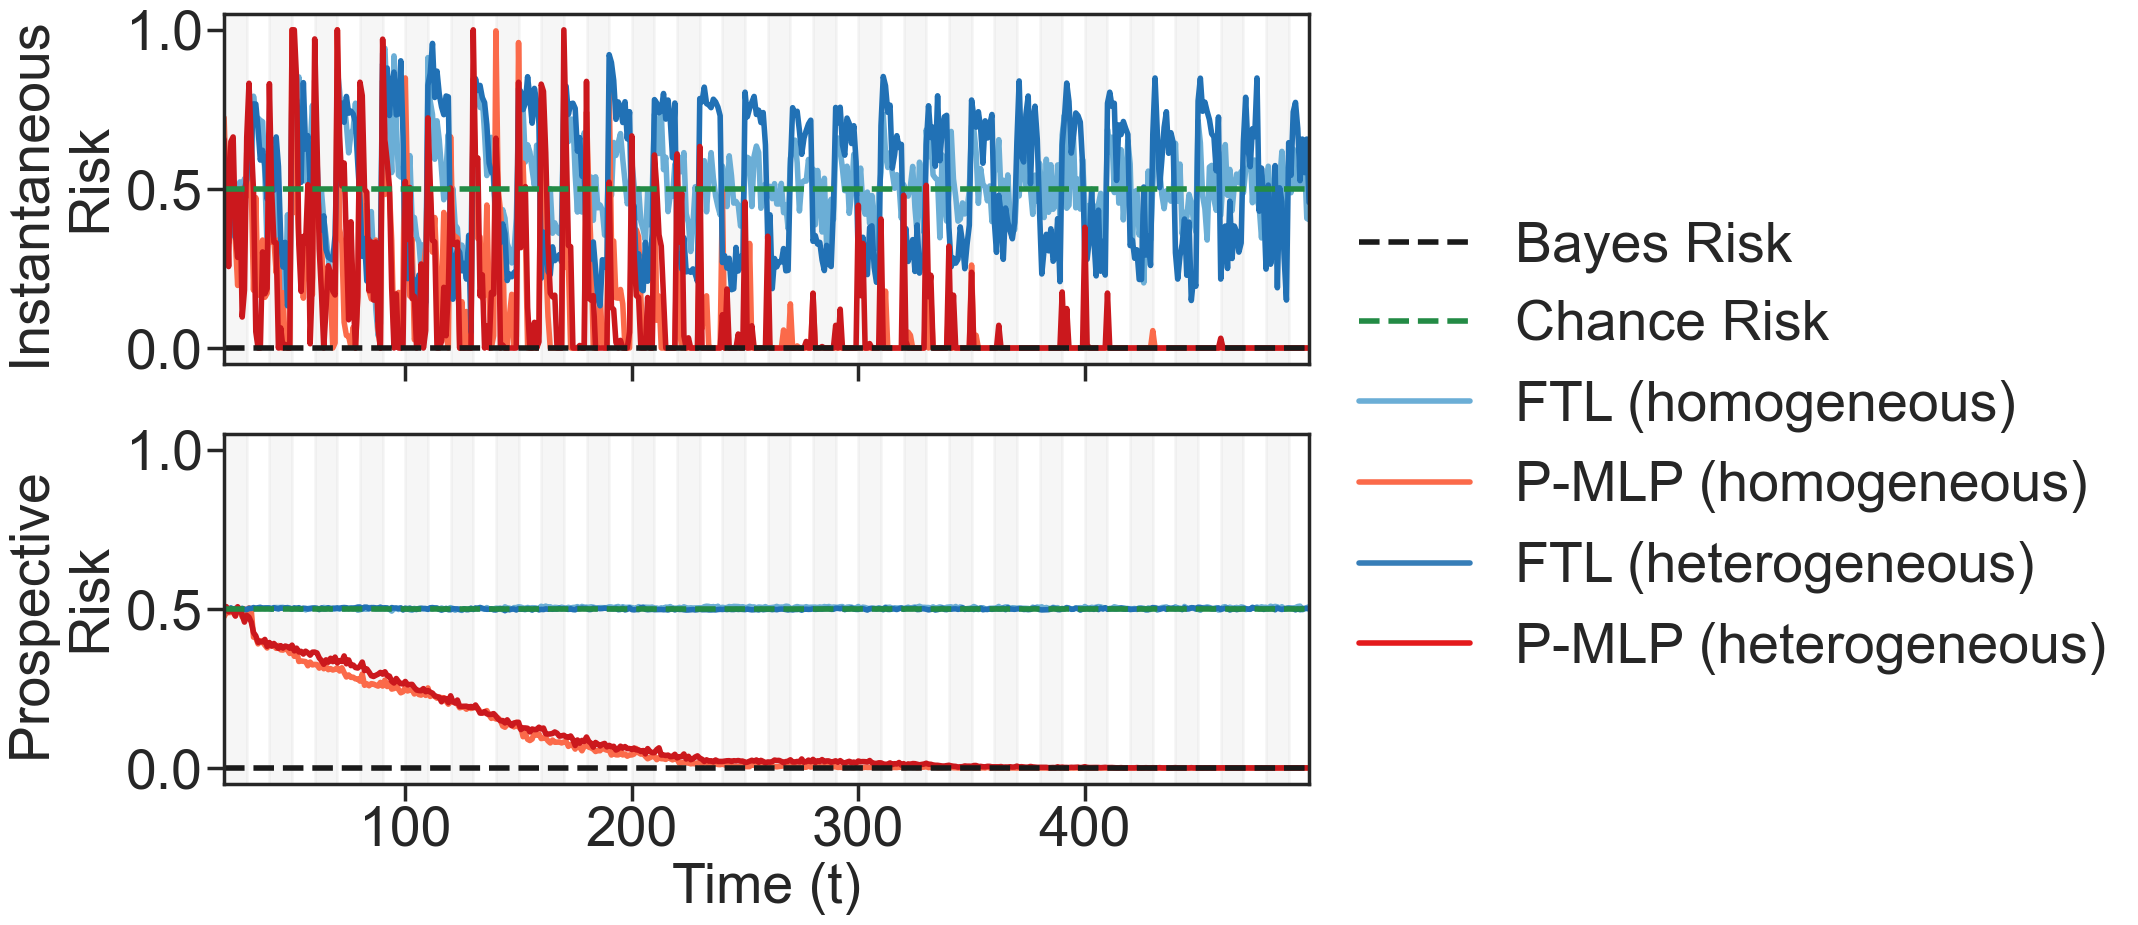

In [5]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
colors = ['#377eb8', '#e41a1c', '#4daf4a', '#984ea3']

methods = ["FTL", "Prospective"]
fontsize = 40
lw = 4

file = '../results/results_lambda_0_p_0.0.pkl'
results = load_results(file)
instant_risk = results['irisk']
prospective_risk = results['prisk']

colors = ['#6baed6', '#fb6a4a']
for i, method in enumerate(methods):
    ax = axes[0]
    ax.plot(t_list, instant_risk[method], color=colors[i], lw=lw, label=method)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax = axes[1]
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

file = '../results/results_lambda_1_p_0.0.pkl'
results = load_results(file)
instant_risk = results['irisk']
prospective_risk = results['prisk']

colors = ['#2171b5', '#cb181d']
for i, method in enumerate(methods):
    ax = axes[0]
    ax.plot(t_list, instant_risk[method], color=colors[i], lw=lw, label=method)
    
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

    ax = axes[1]
    ax.plot(t_list, prospective_risk[method], color=colors[i], lw=lw)
    ax.set_yticks([0, 0.5, 1])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlim([t_list[0], t_list[-1]])

switch_times = np.arange(0, t_list[-1]+2, period//2)
for i in range(0, len(switch_times)-1, 2):
    for j in range(0, 2):
        ax = axes[j]
        ax.fill_betweenx([-0.1, 1.1], switch_times[i], switch_times[i+1], color='lightgray', alpha=0.2)
        
for j in range(0, 2):
    ax = axes[j]
    ax.plot(t_list, np.zeros_like(t_list), lw=lw, ls='dashed', color='k', label="Bayes Risk")

for j in range(0, 2):
    ax = axes[j]
    ax.plot(t_list, 0.5*np.ones_like(t_list), lw=lw, ls='dashed', color='#238b45', label="Bayes Risk")


axes[0].grid(visible=False)
axes[1].grid(visible=False)

legend_elements = [
    Line2D([0], [0], color='k', lw=4, ls='dashed', label='Bayes Risk'),
    Line2D([0], [0], color='#238b45', lw=4, ls='dashed', label='Chance Risk'),
    Line2D([0], [0], color='#6baed6', lw=4, label='FTL (homogeneous) '),
    Line2D([0], [0], color='#fb6a4a', lw=4, label='P-MLP (homogeneous)'),
    Line2D([0], [0], color='#377eb8', lw=4, label='FTL (heterogeneous)'),
    Line2D([0], [0], color='#e41a1c', lw=4, label='P-MLP (heterogeneous)'),
]

ax = axes[0]
ax.legend(
    handles=legend_elements, 
    frameon=False, 
    loc='upper left', 
    bbox_to_anchor=(1, 0.55),
    fontsize=fontsize   
)

axes[0].set_ylabel("Instantaneous \n Risk", fontsize=fontsize)
axes[1].set_ylabel("Prospective \n Risk", fontsize=fontsize)
axes[1].set_xlabel("Time (t)", fontsize=fontsize)

axes[0].tick_params(axis='both', labelsize=fontsize)
axes[1].tick_params(axis='both', labelsize=fontsize)

plt.savefig(f"../figures/1_effect_of_data_sparsity.pdf", bbox_inches='tight')
plt.show()